In [ ]:
!pip install tensorflow
!pip install numpy

In [34]:
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [35]:
# Load the data

"""
  - We have 404 training samples and 102 test samples, each with 13 numerical 
  features, such as per capita crime rate, average number of rooms per dwelling,
  accessibility to highways, and so on.

  - The targets are the median values of owner-occupied homes, in thousands 
  of dollars.
"""

(train_data, train_targets), (test_data, test_targets) = (
    boston_housing.load_data()
)

In [36]:
# Prepare the data with feature-wise normalization

"""
  Note that the quantities used for normalizing the test data are computed 
  using the training data. 

  You should never use any quantity computed on the test data in your workflow, 
  even for something as simple as data normalization. 
"""

mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= mean



In [37]:
#  Building the Model

"""
  - The less training data you have, the worse overfitting will be.

  - Use a small model to mitigate this.
"""

def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      # layers.Dense(32, activation="relu"),
      layers.Dense(1)   # No activation is typical for a scalar regression (trying to predict a single continuous value)
                        # If applied a sigmoid activation function to the last layer, the model could only learn to predict values between 0 and 1. 
                        # Because the last layer is purely linear, the model is free to learn to predict values in any range.
  ])

  model.compile(
      optimizer="rmsprop",
      loss="mse", # Mean squared error - square of the difference between the predictions and the targets (widely used in regression problems)
      metrics=["mae"] # Mean absolute error - Absolute value of the difference between the predictions and the targets.
  )

  return model


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


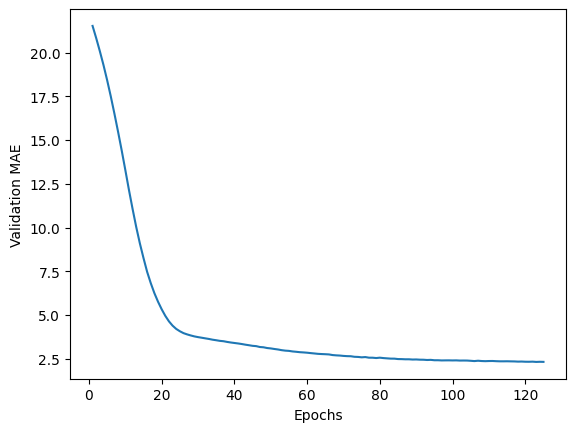

In [38]:
# Validating Model with K-fold validation

"""
  - Split the available data into K partitions (typically K = 4 or 5) 

  - Instantiate K identical models, and train each one on K – 1 partitions 
    while evaluating on the remaining partition. 

  - The validation score for the model used is then the average of the K 
    validation scores obtained. 
"""

k = 4 
num_val_samples = len(train_data) // k
num_epochs = 125 
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)


# Compute average of the per-epoch MAE scores for all folds

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


# Plot Scores

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


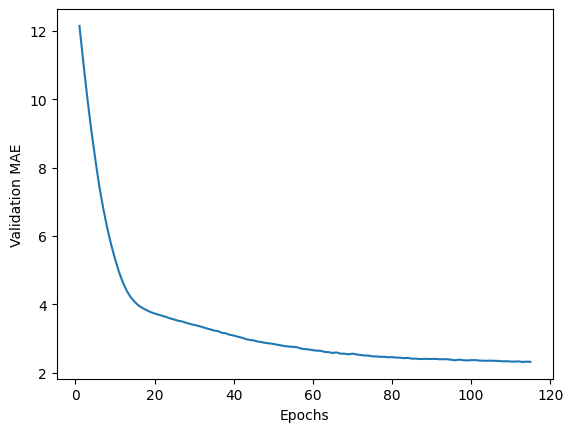

In [39]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [40]:
# Training the final model

model = build_model()
model.fit(
    train_data, 
    train_targets,
    epochs=125,
    batch_size=16,
    verbose=0
)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

4/4 [==============================] - 0s 7ms/step - loss: 120.7795 - mae: 7.0525
7.05248498916626


## Key Takeaways

* Regression is a technique used to predict a continuous numerical value based on a set of input features. The goal of regression is to find the relationship between the input features and the output value, and use that relationship to make predictions on new data.
* Use different loss functions for regression (typically mse)
* The concept of accuracy doesn't apply for regression. Use MAE instead
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step
* When there is little data available, use K-fold validation. Additionally, use a small model with few intermediate steps to avoid overfitting.
